In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy
from nltk import Tree
import seaborn as sns

In [2]:
class Encoder:
    """
    Description
    --------------
    Class represeting the one-hot encoder of the states.
    """
    
    def __init__(self, categories=[4, 3, 3, 3, 2, 4]):
        """
        Description
        --------------
        Constructor of class Encoder.
        
        Parameters & Attributes
        --------------
        categories : List of length d where categories[i] is the number of categories feature i can take.
        d          : Int, the input dimension.
        dim        : Int, the one-hot encoded representation dimension
        
        """
        
        self.categories = categories
        self.d = len(categories)
        self.dim = np.sum(categories) + self.d
        
    def transform(self, state_values):
        """
        Description
        --------------
        Encode the vector state representation with dummies.
        
        Parameters & Attributes
        --------------
        state_values : List of length d where the ith entry is either NaN or the the feature value.
        
        Returns
        --------------
        state_one_hot : 2D np.array representing the one-hot encoded state.
        """
    
        s = 0
        state_one_hot = np.zeros((1, self.dim), dtype = np.float32)
        for i, value in enumerate(state_values):
            if np.isnan(value):
                state_one_hot[0, self.categories[i] + s] = 1

            else:
                state_one_hot[0, value + s] = 1

            s += self.categories[i]+1

        return state_one_hot

In [3]:
class State:
    """
    Description
    --------------
    Class representing a state, it also serves as Node representation
    for our Breadth First Search
    """
    
    def __init__(self, values, encoder, categories=[4, 3, 3, 3, 2, 4]):
        """
        Description
        --------------
        Constructor of class State.
        
        Parameters & Attributes
        --------------
        values     : List of length d (Input dimension):
                         - values[i] = NaN if i is an unobsorved feature.
                         - values[i] = value of feature i if it is observed.
        encocer    : sklearn.preprocessing._encoders.OneHotEncoder object.
        categories : List of length d where categories[i] is the number of categories feature i can take.
        observed   : List containing the observed features at this state.
        unobserved : List containing the unobserved features at this state.
        empty      : Boolean, whether it is the empty state or not.
        complete   : Boolean, whether all features are observed or not.
        """
        
        d = len(values)
        values_nans = np.isnan(values)
        self.encoder = encoder  # One-hot encoder, used in the approximate RL framework for state representation.
        self.values = values
        self.values_encoded = self.encode()
        self.categories = categories
        self.observed = np.arange(d)[np.invert(values_nans)]
        self.unobserved = np.arange(d)[values_nans]  # These are also the allowed query actions at this state
        self.empty = (len(self.observed) == 0)
        self.complete = (len(self.unobserved) == 0)
        
    def encode(self):
        """
        Description
        --------------
        Encode the state with dummy variables. To be used when a one-hot encoder is defined.
        
        Parameters
        --------------
        
        Returns
        --------------
        np.array of shape (1, #one_hot_representation_dim)
        """
        
        return self.encoder.transform(self.values)
        
    def __repr__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s
    
    def __str__(self):
        """
        Description
        --------------
        String representation of the state.
        """
        
        s = '| '
        for x in self.values:
            s += str(x) + ' | '
            
        return s

In [4]:
class Policy(nn.Module):
    
    def __init__(self, input_size=25, out=8):
        """
        Description
        ---------------
        Constructor of Deep Q-network class.
        
        Parameters
        ---------------
        input_size : Int, the one-hot encoding representation dimension.
        out        : Int, output dimension, equal to the number of possible actions.
        fc_1       : nn.Linear, first fully connected layer.
        fc_2       : nn.Linear, second fully connected layer.
        output     : nn.Linear, output fully connected layer.
        """
        
        super(Policy, self).__init__()
        
        self.fc_1 = nn.Linear(input_size, 32)
        self.fc_2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, out)
        
        # Initialization
        nn.init.constant_(self.fc_1.weight, 0)
        nn.init.constant_(self.fc_1.bias, 0)
        nn.init.constant_(self.fc_2.weight, 0)
        nn.init.constant_(self.fc_2.bias, 0)
        nn.init.constant_(self.output.weight, 0)
        nn.init.constant_(self.output.bias, 0)
        
    def forward(self, x):
        """
        Description
        ---------------
        The forward pass.
        
        Parameters
        ---------------
        x : torch.tensor of dimension (batch_size, input_size)
        
        Returns
        ---------------
        torch.tensor of dimension (batch_size, out)
        """
        
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        return self.output(x)


In [5]:
class Environment:
    """
    Description
    --------------
    Class representing the environment, it can generate data points that start each episode,
    keep track of the current state, return the reward of an action taken at the current state,
    and transition to the next corresponding state.
    """
    
    def __init__(self, generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=3):
        """
        Description
        --------------
        Constructor of class Environment.
        
        Parameters & Attributes
        --------------
        generator       : Dict, - keys   : Feature variables.
                                - values : List of probability masses of each category of the corresponding feature.
        rewards_queries : Dict, - keys   : Feature variables.
                                - values : Reward of querying the value of the corresponding feature.
        encocer         : sklearn.preprocessing._encoders.OneHotEncoder object.
        r_plus          : Int, reward of a correct report (default=5).
        r_minus         : Int, reward of an incorrect report (default=-5).
        split           : Int, the split point we use to define our concept.
        d               : Int, the number of feature variables.
        data_point      : List of length d, the data point starting the episode.
        label           : Boolean, the true label of data_point.
        state           : Object of class State, the current state.
        done            : Boolean, whether the episode is finished or not.
        """
        
        self.generator = generator
        self.categories = [len(v) for v in self.generator.values()]
        self.d = len(self.categories)
        self.rewards_queries = rewards_queries
        self.encoder = encoder
        self.r_plus = r_plus
        self.r_minus = r_minus
        self.split = split
        
    def generate(self):
        """
        Description
        --------------
        Generate a data point.
        
        Parameters
        --------------
        
        Returns
        --------------
        List with the values of each feature, it represents the data point.
        """
        
        return [np.random.choice(self.categories[i], p=self.generator[i]) for i in range(self.d)]
    
    def concept(self, data_point):
        """
        Description
        --------------
        Define the concept labeling the data points. we can define it as a decision tree for example.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the label of the data point.
        """
        
        label = True
        i = 0
        while label and i <= self.d-1:
            if data_point[i] >= self.split:
                label = False
                
            i += 1
            
        return label
    
    def reset(self, data_point=None):
        """
        Description
        --------------
        Reset the environment to start a new episode. If data_point is specified, start the episode from it,
        otherwise generate it.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label (default=None).
        
        Returns
        --------------
        """
        
        self.data_point = self.generate() if data_point is None else data_point
        self.label = self.concept(self.data_point)
        self.state = State([np.NaN for i in range(self.d)], self.encoder, categories=self.categories)
        self.done = False
    
    def step(self, action):
        """
        Description
        --------------
        Interract with the environment through an action taken at the current state.
        
        Parameters
        --------------
        action : Int in {0, ..., d-1, d, d+1}, 
                 - 0, ..., d-1 represent query actions.
                 - d, d+1 represent report actions.
        
        Returns
        --------------
        reward     : Int, the reward of taking this action at the current state.
        next_state : Object of class State, the next state.
        done       : Boolean, whether the episode is finished or not.
        """
        
        # Treating query actions.
        if action <= self.d-1:
            # If it is an allowed query action.
            if np.isnan(self.state.values[action]):
                reward = self.rewards_queries[action]
                values = self.state.values
                values[action] = self.data_point[action] # Reveal the value of the queried feature in the data point.
                self.state = State(values, self.encoder, self.categories)
                
            # If this query action is not allowed.
            else:
                print('unallowed')
            
        # Treating report actions.
        else:
            reward = self.r_plus if (action%self.d) == self.label else self.r_minus
            self.done = True
            
        return reward, self.state, self.done

In [6]:
class DQNetwork(nn.Module):
    
    def __init__(self, input_size=25, out=8):
        """
        Description
        ---------------
        Constructor of Deep Q-network class.
        
        Parameters
        ---------------
        input_size : Int, the one-hot encoding representation dimension.
        out        : Int, output dimension, equal to the number of possible actions.
        fc_1       : nn.Linear, first fully connected layer.
        fc_2       : nn.Linear, second fully connected layer.
        output     : nn.Linear, output fully connected layer.
        """
        
        super(DQNetwork, self).__init__()
        
        self.fc_1 = nn.Linear(input_size, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_3 = nn.Linear(32, 32)
        self.output = nn.Linear(32, out)
        
    def forward(self, x):
        """
        Description
        ---------------
        The forward pass.
        
        Parameters
        ---------------
        x : torch.tensor of dimension (batch_size, input_size)
        
        Returns
        ---------------
        torch.tensor of dimension (batch_size, out)
        """
        
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        return self.output(x)


In [7]:
class Agent:
    """
    Description
    --------------
    Class describing a DQN agent
    """
    
    def __init__(self, gamma=.9, categories=[4, 3, 3, 3, 2, 4], labels=[0, 1]):
        """
        Description
        --------------
        Constructor of class AgentDQN.
        
        Parameters & Attributes
        --------------
        gamma           : Float in ]0, 1[, the discount factor (default=0.9).
        categories      : List of length d where categories[i] is the number of categories feature i can take.
        labels          : List of the possible labels.
        d               : Int, the number of feature variables.
        b               : Int, the number of class labels.
        actions         : List of all actions.
        actions_queries : List of query actions.
        actions_report  : List of report actions.

        Returns
        --------------
        """
        
        self.gamma = gamma
        self.categories = categories
        self.labels = labels
        self.d = len(categories)
        self.b = len(labels)
        self.actions = range(self.d + len(labels))
        self.actions_queries = range(d)
        self.actions_report = [self.d + label for label in labels]
        self.policy = Policy(input_size=np.sum(categories)+self.d, out=self.d+self.b)
#         self.q_network = DQNetwork(input_size=np.sum(categories)+self.d, out=self.d+self.b)
#         self.q_network.load_state_dict(torch.load('ddqn_weights.pth'))
        
        
    def actions_probas(self, state):
        """
        Description
        --------------
        Calculate the probabilities of the allowed actions at a state.
        
        Parameters
        --------------
        state   : Object of class State.
        
        Returns
        --------------
        actions_probas  : torch.tensor of size #Allowed_actions, with the allowed actions probabilities.
        actions_allowed : List of the allowed actions.
        """
        
        actions_output = self.policy(torch.from_numpy(state.values_encoded))
        actions_allowed = list(state.unobserved) + [self.d+i for i in range(self.b)]
        actions_probas = F.softmax(actions_output[0, actions_allowed], dim=0)
        return actions_probas, actions_allowed
        
    def action(self, state):
        """
        Description
        --------------
        Choose an action at a state by sampling from the current stochastic policy.
        
        Parameters
        --------------
        state  : Object of class State.
        
        Returns
        --------------
        action, action_proba : Int in {0, ..., d-1, d, d+1}, Float in [0, 1]
        """
        
        actions_probas, actions_allowed = self.actions_probas(state)
        index = np.random.choice(len(actions_allowed), p=actions_probas.detach().numpy())
        action, action_proba = actions_allowed[index], actions_probas[index]
        return action, action_proba, index
    
    def action_greedy(self, state):
        """
        Description
        --------------
        Choose the action maximizing the stochastic policy at the state.
        
        Parameters
        --------------
        state  : Object of class State.
        
        Returns
        --------------
        action : Int in {0, ..., d-1, d, d+1}
        """
        
        with torch.no_grad():
            actions_probas, actions_allowed = self.actions_probas(state)
            return actions_allowed[torch.argmax(actions_probas).item()]
        
        
    def train(self, env, n_train=1000, lr=1e-4, log_dir='runs_pg/', n_prints=1000):
        """
        Description
        --------------
        Explore the environment and train the agent.
        
        Parameters
        --------------
        env      : Object of class Environment.
        n_train  : Int, number of training episodes.
        lr       : Float, the learning rate.
        log_dir  : String, path of the folder where tensorboard events are stored.
        n_prints : Int, the number of iterations between two consecutive prints.
        
        Returns
        --------------
        """
        
        writer = SummaryWriter(log_dir=log_dir)
        optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        variables = {'return' : []}
        for episode in range(n_train):
            env.reset()
            state = deepcopy(env.state)
            states, actions_indices, actions, rewards_gamma = [], [], [], []
            step = 0
            while not env.done:
                action, action_proba, action_index = self.action(state)
                reward, next_state, _ = env.step(action)
                states.append(state)
                actions_indices.append(action_index)
                actions.append(action)
                rewards_gamma.append((self.gamma**step)*torch.tensor(reward, dtype=torch.float32, requires_grad=False).reshape(-1, 1))
                state = deepcopy(next_state)
                variables['return'].append(reward)
                step += 1
                
            # Learning phase.
            rewards_gamma_episode = torch.cat(rewards_gamma).flip(0, 1).cumsum(0).flip(0, 1)
            for t in range(step):
                state, action_index, action = states[t], actions_indices[t], actions[t]
                actions_probas, actions_allowed = self.actions_probas(state)
                ln_action_proba = torch.log(actions_probas[action_index])
                loss = -((self.gamma**(-t))*rewards_gamma_episode[t, 0])*ln_action_proba
#                 loss = -((self.gamma**(-t))*rewards_gamma_episode[t, 0] - self.q_network(torch.from_numpy(state.values_encoded)).mean().item())*ln_action_proba
#                 loss = -self.q_network(torch.from_numpy(state.values_encoded))[0, action]*ln_action_proba
                optimizer.zero_grad()
                if t == step-1:
                    loss.backward()
                    
                else:
                    loss.backward(retain_graph=True)
                    
                optimizer.step()
            
            writer.add_scalar('Return', np.sum(variables['return']), episode)
            variables['return'] = []
            if episode%n_prints == 0:
                print('Episode : %d' %(episode))
                        
        writer.close()
        
    def predict(self, env, data_point):
        """
        Description
        --------------
        Predict the label of a data point.
        
        Parameters
        --------------
        
        Returns
        --------------
        """
        
        env.reset(data_point)
        state = env.state
        while not env.done:
            action = agent.action_greedy(state)
            env.step(action)
            state = env.state
        
        return action%self.d
        
    def test(self, env, n_test=1000):
        """
        Description
        --------------
        Test the agent on n_test data points generated by env.
        
        Parameters
        --------------
        env      : Object of class Environment.
        n_test   : Int, number of data points to test the agent on.
        
        Returns
        --------------
        accuracy : FLoat in [0, 1], the accuracy of the agent on this test.
        """
        
        valids = 0
        for i in range(n_test):
            data_point = env.generate()
            env.reset(data_point)
            label_pred, label_true = self.predict(env, data_point), env.label
            valids += (label_pred==label_true)
            
        return valids/n_test
    
    def save_weights(self, path):
        """
        Description
        --------------
        Save the agents q-network weights.
        
        Parameters
        --------------
        path: String, path to a .pth file containing the weights of a q-network.
        
        Returns
        --------------
        """
        
        torch.save(self.policy.state_dict(), path)
    
    def load_weights(self, path):
        """
        Description
        --------------
        Load the weights of a q-network.
        
        Parameters
        --------------
        path: String, path to a .pth file containing the weights of a q-network.
        
        Returns
        --------------
        """
        
        self.policy.load_state_dict(torch.load(path))
        
    def children(self, state):
        """
        Description
        --------------
        Give the possible outcomes of taking the greedy policy at the considered state.
        
        Parameters
        --------------
        state : Object of class State.
        
        Returns
        --------------
        children : Set of objects of class State.
        action   : Int, action taken at state with the agent policy.
        """
        
        children = []
        action = self.action_greedy(state)
        if action >= self.d: return children, action
        for category in range(self.categories[action]):
            values = state.values.copy()
            values[action] = category
            children.append(State(values, state.encoder, self.categories))

        return children, action
    
    def build_string_state(self, state):
        """
        Description
        --------------
        Build string representation of the agent decision (with parentheses) starting from state.
        
        Parameters
        --------------
        state : Object of class State.
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        l, action = self.children(state)
        if action >= self.d: return str(self.action_greedy(state)%self.d) + ''
        string = ''
        for child in l:
            string += '(X_' + str(action) + '=' + str(child.values[action]) + ' ' + self.build_string_state(child) + ') '

        return string
    
    def build_string(self, encoder):
        """
        Description
        --------------
        Build string representation of the agent decision.
        
        Parameters
        --------------
        
        Returns
        --------------
        string : String representation of a tree.
        """
        
        return '( ' + self.build_string_state(State([np.NaN for i in range(self.d)], encoder, self.categories)) + ')'
    
    def plot_tree(self, encoder):
        """
        Description
        --------------
        Plot the agent's decision tree.
        
        Parameters
        --------------
        
        Returns
        --------------
        nltk tree object, helpful to visualize the agent's decision tree policy.
        """

        return Tree.fromstring(self.build_string(encoder))
        
        
            
            

In [8]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
labels = [0, 1]
d, b = len(categories), len(labels)
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

# Define ethe encoder
encoder = Encoder(categories=categories)

In [9]:
env = Environment(generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=4)
agent = Agent(categories=categories)

In [10]:
# l = []
# for i in range(10000):
#     data_point = env.generate()
#     l.append(env.concept(data_point))

# print('Fraction of 1 labeled points : %.5f' %(np.sum(l)/10000))

In [11]:
agent.train(env, n_train=100000, lr=1e-3)

Episode : 0
Episode : 1000
Episode : 2000
Episode : 3000
Episode : 4000
Episode : 5000
Episode : 6000
Episode : 7000
Episode : 8000
Episode : 9000
Episode : 10000
Episode : 11000
Episode : 12000
Episode : 13000
Episode : 14000
Episode : 15000
Episode : 16000
Episode : 17000
Episode : 18000
Episode : 19000
Episode : 20000
Episode : 21000
Episode : 22000
Episode : 23000
Episode : 24000
Episode : 25000
Episode : 26000
Episode : 27000
Episode : 28000
Episode : 29000
Episode : 30000
Episode : 31000
Episode : 32000
Episode : 33000
Episode : 34000
Episode : 35000
Episode : 36000
Episode : 37000
Episode : 38000
Episode : 39000
Episode : 40000
Episode : 41000
Episode : 42000
Episode : 43000
Episode : 44000
Episode : 45000
Episode : 46000
Episode : 47000
Episode : 48000
Episode : 49000
Episode : 50000
Episode : 51000
Episode : 52000
Episode : 53000
Episode : 54000
Episode : 55000
Episode : 56000
Episode : 57000
Episode : 58000
Episode : 59000
Episode : 60000
Episode : 61000
Episode : 62000
Episo

In [12]:
# agent.load_weights('pg_weights.pth')

In [20]:
agent.test(env, 10000)

0.5887

In [21]:
labels_pred, labels_true = [], []
for i in range(10000):
    data_point = env.generate()
    labels_pred.append(agent.predict(env, data_point))
    labels_true.append(env.concept(data_point))

In [22]:
print('Number of true ones      : %d' %np.sum(labels_true))
print('Number of predicted ones : %d' %np.sum(labels_pred))

Number of true ones      : 4205
Number of predicted ones : 0


In [23]:
depths = []
for i in range(1000):
    data_point = env.generate()
    env.reset(data_point)
    state = env.state
    depth = 0
    while not env.done:
#         action, _, _ = agent.action_greedy(state)
        action = agent.action_greedy(state)
        _, state, _ = env.step(action)
        depth += 1
        
    depths.append(depth)

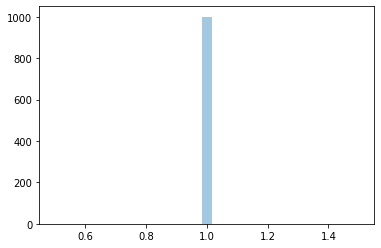

In [24]:
sns.distplot(depths, kde=False)

In [25]:
set(depths)

{1}

In [26]:
agent.policy(torch.from_numpy(State([np.NaN for i in range(d)], encoder).values_encoded))

tensor([[-1.5374, -1.2231, -1.2651, -1.4924, -1.8946, -0.6104, -2.6298, -2.4570,
         -2.8781, -1.0633, -1.4204, -1.7187, -1.0419, -1.2124, -2.6216,  6.9567,
         -2.7422]], grad_fn=<AddmmBackward>)

In [29]:
for i in range(5, 0, -1):
    print(i)

5
4
3
2
1


In [36]:
torch.FloatTensor([torch.tensor(1), torch.tensor(1)])

torch.float32

In [38]:
a = torch.tensor(1)